# Recognizing handwritten signatures
We hope to distinguish between real and forged signatures

In [1]:
# import required modules, packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

# import datasets, classifiers, performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
# accessing the dataset
from PIL import Image, ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

p = Path("sample_Signature/")
dirs = p.glob("*")
labels_dict = {'forge':0, 'genuin':1}

image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]

    for img_path in folder_dir.glob("*.png"):
        # reading/opens each image
        img = Image.open(img_path)
        if 'L' in img.getbands():  # image is black-and-white, colorize it
            img = ImageOps.colorize(img, black="blue", white="white")
        # resizing each image
        img_new = img.resize((200,200))
        # convert each image to array using numpy
        img_array = np.asarray(img_new)
        # append each image array to image_data list
        image_data.append(img_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # image color inversion
        from skimage import util
        import numpy as np
        color_inversion_img = util.invert(img_array)
        # alternate method with numpy
        #color_inversion_img_w_np = np.invert(img)
        img_invert_array = np.asarray(color_inversion_img)
        # append each image array to image_data list
        image_data.append(img_invert_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

In [3]:
print(len(image_data))
print(len(labels))

600
600


In [4]:
image_data = np.array(image_data, dtype = 'float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(600, 200, 200, 3) (600,)


In [5]:
import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

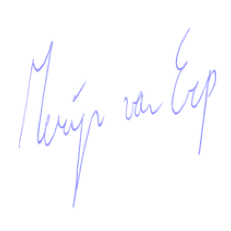

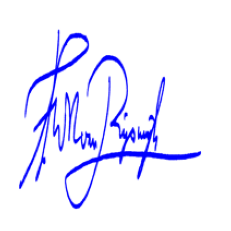

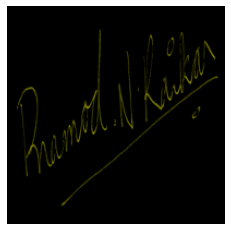

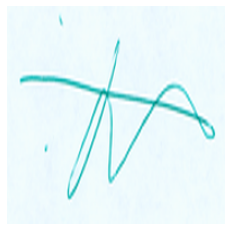

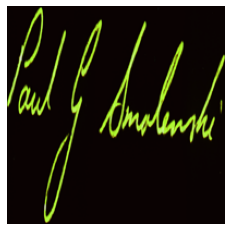

In [6]:
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

# 10 example visualizations
for i in range(5):
    drawImg(image_data[i])

# SVC Classification

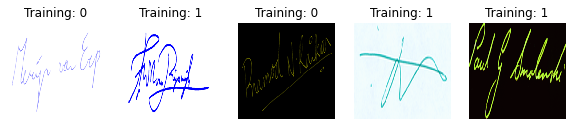

In [7]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

# OG example used 'digits.images' and 'digits.target' instead of 'image_data' and 'labels'
for ax, image, label in zip(axes, image_data, labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [8]:
# to use a classifier, first need to flatten images, convert to grayscale

# flatten images
n_samples = len(image_data)
data = image_data.reshape((n_samples, -1))

# create a classifier: support vector classifier
clf = svm.SVC(gamma = 0.001)

# split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size =0.5, shuffle = False)

# learn the signatures on the train subset
clf.fit(X_train, y_train)

# predict the signature (forge or real) on the test subset
predicted = clf.predict(X_test)

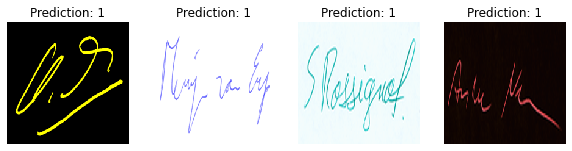

In [9]:
# take samples to predict and visualize
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(200, 200, 3)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [10]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.67      0.45      0.54       143
           1       0.61      0.80      0.69       157

    accuracy                           0.63       300
   macro avg       0.64      0.62      0.61       300
weighted avg       0.64      0.63      0.62       300




# Keras Classification

In [11]:
X_train.shape

(300, 120000)

In [12]:
X_train[0]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [13]:
model = keras.Sequential([
    keras.layers.Dense(2,input_shape=(120000,), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

model.fit(X_train,y_train, epochs = 10)

Epoch 1/10
10/10 [==============================] - 0s 12ms/step - loss: 37.0883 - accuracy: 0.5400
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 26.6813 - accuracy: 0.4967
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 13.6742 - accuracy: 0.5367
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 12.2592 - accuracy: 0.4800
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 3.3941 - accuracy: 0.5767
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 5.3697 - accuracy: 0.5833
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 6.5963 - accuracy: 0.5733
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 8.5800 - accuracy: 0.5867
Epoch 9/10
10/10 [==============================] - 0s 15ms/step - loss: 8.7171 - accuracy: 0.5867
Epoch 10/10
10/10 [==============================] - 0s 15ms/step - loss: 12.8538 - accuracy: 0.5733


In [14]:
model.evaluate (X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 15.0506 - accuracy: 0.5033


[15.050644874572754, 0.503333330154419]

# Serialization


In [15]:
#check if a model has already been saved and if it hasn't, save it to the disk
#This is basically the serialization
'''import os.path
if os.path.isfile('models/Real_Forged_signatures.h5') is False:
    model.save('models/Real_Forged_signatures.h5')
    '''
json_string = model.to_json()

In [16]:
json_string

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 120000], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_input"}}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 120000], "dtype": "float32", "units": 2, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}]}, "keras_version": "2.6.0", "backend": "tensorflow"}'

# Deserialization

In [17]:
# Deserialization
from tensorflow.keras.models import model_from_json
model_architecture = model_from_json(json_string)

# Joblib Serialization and Deserialization
having some trouble with the pkl file being too large/not displaying

In [18]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']

In [19]:
clf = joblib.load('model.pkl')